In [1]:
pip install shap

     |████████████████████████████████| 358kB 12.4MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491619 sha256=a74e53249d6608d33939d5976ea624d8b5167016382a323894613b563482a664
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [2]:
pip install -U scikit-learn

     |████████████████████████████████| 22.3MB 25.2MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


# Import Libraries 

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedKFold
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import shap
import warnings
import io
from IPython.display import display, HTML
from sklearn import svm
import matplotlib.pyplot as plt
import seaborn as sn
from pickle import dump, load
from urllib.request import urlopen
from google.colab import files

In [4]:
df = pd.read_excel('https://drive.google.com/uc?id=1cHBlV6aQ_xzwhCNvanSgLKIA8k0gcqkv', header=0)
df['IDATE']=df['IDATE'].dt.strftime('%m%d').astype(int)
df.head()

,IDATE,LAT,LON,ELEVATION_m,ACRES,PPT_mm,TMIN_c,TMAX_c,VPD9AM_hpa,VPD3PM_hpa,lfmc_mean,lfmc_stdv,NAMELSAD,population,Station_TDMEAN_c,Mean_Sea_Level_Pressure,Mean_Station_Pressure,Mean_Wind_Speed,Maximum_Sustained_Wind_Speed,TMEAN_c
0,101,-31.3497,116.0366,206,850.9043,0.0,13.40,29.32,15.27,15.10,36.224998,18.932627,Chittering (S),2948,12.8,1011.7,992.4,17.3,43.9,21.360
1,101,-32.1413,116.1956,266,18.3947,0.0,14.58,29.39,14.62,14.69,61.924999,16.209669,Armadale (C),52391,13.0,1011.8,993.0,14.8,43.9,21.985
2,101,-32.0572,116.1932,312,0.4853,0.0,14.32,29.14,14.67,14.76,66.547501,13.480727,Kalamunda (C),48743,13.3,1011.7,992.9,15.2,43.9,21.730
3,101,-32.0542,116.1940,311,5.3271,0.0,14.32,29.14,14.67,14.76,61.877499,13.119061,Kalamunda (C),48743,13.3,1011.7,992.9,15.2,43.9,21.730
4,101,-32.0476,116.1925,309,0.5353,0.0,14.32,29.14,14.67,14.76,83.957497,14.985291,Kalamunda (C),48743,13.3,1011.7,992.9,15.2,43.9,21.730


In [5]:
#identify string categorical variables
categorical_feature_mask = df.dtypes == object
categorical_cols = df.columns[categorical_feature_mask].tolist()
le = LabelEncoder() #Original
#Load already saved encoder values
#le = load(urlopen('https://drive.google.com/uc?id=1z4mtk-D0MpecEQof9aFYCwk949OMJoTc'))
#Convert categorical variables into encoded numbers
df[categorical_cols] = df[categorical_cols].apply(lambda col: le.fit_transform(col.astype(str))) #Original
#Apply saved encorder values
#df[categorical_cols] = df[categorical_cols].apply(lambda col: le.transform(col.astype(str)))
print("Size of data set : "+str(df.shape[0]))
#Drop rows with any NaN or NaT
df=df.dropna()
df_original=df.copy()
print("Size of data set after droping NaN values : "+str(df.shape[0]))
#Scale the data and covert it back to Pandas data frame
scalar=StandardScaler() #Original
#Load already saved scalar values
#scalar=load(urlopen('https://drive.google.com/uc?id=1OatDlJwOHaDSX4FE0IwMupmWBHuCBAX4'))
df = pd.DataFrame(scalar.fit_transform(df), index=df.index, columns=df.columns)
#apply saved scalar values
#df = pd.DataFrame(scalar.transform(df), index=df.index, columns=df.columns)
X_train, X_test = train_test_split(df, test_size=0.2, random_state=1, shuffle=False)
#Labels for PyOD 0 = inlier, 1 = outlier 
y_train=np.ones(X_train.shape[0])
y_test=np.ones(X_test.shape[0])
print("Train set data size : "+str(X_train.shape))
print("Test set data size : "+str(X_test.shape))

Size of data set : 33300
Size of data set after droping NaN values : 33300
Train set data size : (26640, 20)
Test set data size : (6660, 20)


In [6]:
le.classes_

array(['Albany (C)', 'Armadale (C)', 'Ashburton (S)',
       'Augusta-Margaret River (S)', 'Beverley (S)', 'Boddington (S)',
       'Boyup Brook (S)', 'Bridgetown-Greenbushes (S)', 'Brookton (S)',
       'Broomehill-Tambellup (S)', 'Bruce Rock (S)', 'Bunbury (C)',
       'Busselton (C)', 'Capel (S)', 'Carnamah (S)', 'Carnarvon (S)',
       'Chapman Valley (S)', 'Chittering (S)', 'Cockburn (C)',
       'Collie (S)', 'Coorow (S)', 'Cranbrook (S)', 'Cuballing (S)',
       'Dalwallinu (S)', 'Dandaragan (S)', 'Dardanup (S)', 'Denmark (S)',
       'Donnybrook-Balingup (S)', 'Dowerin (S)', 'Dumbleyung (S)',
       'East Pilbara (S)', 'Exmouth (S)', 'Gingin (S)', 'Gnowangerup (S)',
       'Goomalling (S)', 'Gosnells (C)', 'Greater Geraldton (C)',
       'Harvey (S)', 'Irwin (S)', 'Jerramungup (S)', 'Joondalup (C)',
       'Kalamunda (C)', 'Karratha (C)', 'Katanning (S)',
       'Kellerberrin (S)', 'Kent (S)', 'Kojonup (S)', 'Kondinin (S)',
       'Kulin (S)', 'Kwinana (C)', 'Lake Grace (S)', '

#### Save transformed data set and download

In [7]:
#df.to_excel('scaled_data_set.xlsx')
#files.download('scaled_data_set.xlsx')

### Save transfomation functions and download them for reuse. 

In [8]:
# dump(le, open('wa_label_encorder.pkl', 'wb'))
# files.download('wa_label_encorder.pkl')

In [9]:
# dump(scalar, open('wa_scalar.pkl', 'wb'))
# files.download('wa_scalar.pkl')

## Hyper Paramter Tuning

In [10]:
#Specify each parameter to find the best value for. Either a range of values or a set of predefined options can be specified for each parameter
space = {'gamma': hp.choice('gamma', ['scale', 'auto']),
        'degree': hp.quniform('degree', 1, 8 ,1),
        'kernel': hp.choice('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'nu': hp.uniform('nu', 0.01, 0.99)
    }

# The objective function is a combination of the learner and the parameters that you want to find the best values for. "model" can be changed to any learner 
# The "accuracy" returned is the result of a five-fold cross validation of the classifier on the training data given a set of values for the parameters
def objective(space):
    model = svm.OneClassSVM(gamma = space['gamma'], 
                            degree = space['degree'],
                            kernel = space['kernel'],
                            nu = space['nu']
                           )
    
    accuracy = cross_val_score(model, X_train, y_train, cv = 5, scoring='accuracy').mean()
    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -accuracy, 'status': STATUS_OK }
 
# "fmin" minimises the objective function i.e. finds the set of parameters that results in the learner's best accuracy    
trials = Trials()
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 80, #Please set to 80
            trials= trials)
best
#{'degree': 2.0, 'gamma': 0, 'kernel': 3, 'nu': 0.01146719540267059} Previouse results for 40 evals
# {'degree': 1.0, 'gamma': 1, 'kernel': 3, 'nu': 0.010366673887009277} this id for 80 evals

100%|██████████| 80/80 [1:50:08<00:00, 82.61s/it, best loss: -0.9865615615615615]


{'degree': 2.0, 'gamma': 0, 'kernel': 3, 'nu': 0.010110569281425332}

In [11]:
dump(trials, open('1_wa_one_class_svm_model_trails.pkl', 'wb'))
files.download('1_wa_one_class_svm_model_trails.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Now we train the learner with the most appropriate values found in "best
# 'gamma': 0  - refers to the parameter in the first element of the 'gamma' array. In this case it's 'scale'
# 'kernel': 2 - refers to the parameter in the third element of the 'kernel' array. In this case it's 'rbf'
# The values for the other two parameters are self-explanatory
estimator = svm.OneClassSVM(nu = 0.01146719540267059, kernel="sigmoid", gamma="scale", degree=2)
#estimator = svm.OneClassSVM(nu = 0.010366673887009277, kernel="sigmoid", gamma="auto", degree=1) #80 Evals. This look overfit
estimator.fit(X_train)
y_pred_train = estimator.predict(X_train)
y_pred_test = estimator.predict(X_test)

In [ ]:
# y_df=estimator.predict(df)
# for j in range(y_df.shape[0]):
#   if y_df[j]!=1:
#     print(j)

###Save and Download Model

In [ ]:
dump(estimator, open('1_wa_one_class_svm_model.pkl', 'wb'))
files.download('1_wa_one_class_svm_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Check Train Data Accuracy

In [ ]:
print("Number of True Values : " + str(np.count_nonzero(y_pred_train == 1)))
print("Number of False Values : " + str(np.count_nonzero(y_pred_train == -1)))
print("accuracy: ", metrics.accuracy_score(y_train, y_pred_train))  
print("precision: ", metrics.precision_score(y_train, y_pred_train, zero_division=1))  
print("recall: ", metrics.recall_score(y_train, y_pred_train, zero_division=1))  
print("f1: ", metrics.f1_score(y_train, y_pred_train, zero_division=1)) 
print(metrics.classification_report(y_train,y_pred_train,zero_division=1))

Number of True Values : 26333
Number of False Values : 307
accuracy:  0.988475975975976
precision:  1.0
recall:  0.988475975975976
f1:  0.9942045947935741
              precision    recall  f1-score   support

        -1.0       0.00      1.00      0.00         0
         1.0       1.00      0.99      0.99     26640

    accuracy                           0.99     26640
   macro avg       0.50      0.99      0.50     26640
weighted avg       1.00      0.99      0.99     26640



### Check Test Data Accuracy

In [ ]:
print("Number of True Values : " + str(np.count_nonzero(y_pred_test == 1)))
print("Number of False Values : " + str(np.count_nonzero(y_pred_test == -1)))
print("accuracy: ", metrics.accuracy_score(y_test, y_pred_test))  
print("precision: ", metrics.precision_score(y_test, y_pred_test, zero_division=1))  
print("recall: ", metrics.recall_score(y_test, y_pred_test, zero_division=1))  
print("f1: ", metrics.f1_score(y_test, y_pred_test, zero_division=1))
print(metrics.classification_report(y_test,y_pred_test,zero_division=1))  

Number of True Values : 6631
Number of False Values : 29
accuracy:  0.9956456456456456
precision:  1.0
recall:  0.9956456456456456
f1:  0.9978180723798059
              precision    recall  f1-score   support

        -1.0       0.00      1.00      0.00         0
         1.0       1.00      1.00      1.00      6660

    accuracy                           1.00      6660
   macro avg       0.50      1.00      0.50      6660
weighted avg       1.00      1.00      1.00      6660



### Repeat KFold Validation

In [ ]:
accuracy = []
precision = []
recall = []
f1 = []
#split 5 means we are considering a test set of 1/5 from total set. i.e. 20%
#cv = KFold(n_splits=5, shuffle=True)
cv = RepeatedKFold(n_splits=5, n_repeats=20, random_state=None)
for train_index, test_index in cv.split(df):
    #print("Train Index: ", train_index)
    #print("Test Index: ", test_index, "\n")
    X_train, X_test= df.iloc[train_index], df.iloc[test_index]
    estimator.fit(X_train)
    y_pred_test = estimator.predict(X_test)
    targs = [1]*y_pred_test.shape[0]
    accuracy.append(metrics.accuracy_score(targs, y_pred_test))
    precision.append(metrics.precision_score(targs, y_pred_test))
    recall.append(metrics.recall_score(targs, y_pred_test))
    f1.append(metrics.f1_score(targs, y_pred_test))

In [ ]:
print("Accuracy : ", accuracy, "\nAccuracy Mean : ", np.mean(accuracy),"\n")
print("Precision : ", precision, "\nPrecision Mean : ", np.mean(precision),"\n")
print("Recall : ", recall, "\nRacall Mean : ", np.mean(recall),"\n")
print("f1 : ", f1, "\nf1 Mean : ", np.mean(f1),"\n")

Accuracy :  [0.9864864864864865, 0.9899399399399399, 0.9887387387387387, 0.9873873873873874, 0.9908408408408408, 0.9884384384384385, 0.9908408408408408, 0.9876876876876877, 0.9900900900900901, 0.9863363363363363, 0.9860360360360361, 0.9893393393393394, 0.9884384384384385, 0.9888888888888889, 0.9887387387387387, 0.989039039039039, 0.9900900900900901, 0.9887387387387387, 0.9854354354354354, 0.9893393393393394, 0.989039039039039, 0.9875375375375376, 0.986936936936937, 0.9884384384384385, 0.9903903903903903, 0.9852852852852853, 0.9872372372372372, 0.9896396396396396, 0.9894894894894894, 0.9906906906906907, 0.9864864864864865, 0.9918918918918919, 0.9885885885885886, 0.9876876876876877, 0.989039039039039, 0.9891891891891892, 0.9911411411411412, 0.984984984984985, 0.9891891891891892, 0.987987987987988, 0.9915915915915916, 0.9872372372372372, 0.987987987987988, 0.9888888888888889, 0.9878378378378379, 0.9893393393393394, 0.987987987987988, 0.9882882882882883, 0.9888888888888889, 0.9884384384384

### Shap value calculation. Here we take sample of 100 to calculate it as total sample get days

In [ ]:
warnings.filterwarnings('ignore')
#k_explainer = shap.KernelExplainer(estimator.predict, shap.sample(X_train, random_state=1))
#k_explainer = shap.KernelExplainer(estimator.predict, X_train)
k_explainer = shap.KernelExplainer(estimator.predict, shap.sample(X_train, random_state=1, nsamples=5000))
X_test_sample=shap.sample(X_test, random_state=1)
k_shap_values = k_explainer.shap_values(X_test_sample) # More Sample Need more time
warnings.filterwarnings('once')

Using 5000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


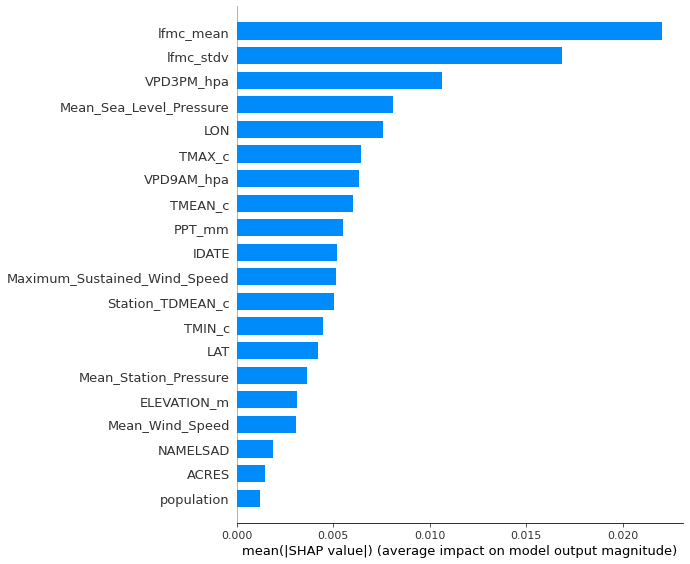

In [ ]:
shap.summary_plot(k_shap_values, X_test_sample, plot_type="bar")

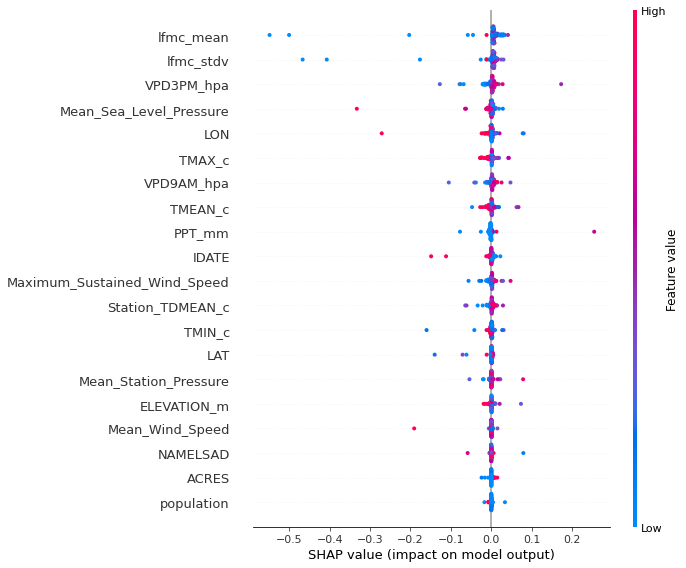

In [ ]:
shap.summary_plot(k_shap_values, X_test_sample)

In [ ]:
shap.initjs()
shap.force_plot(k_explainer.expected_value, k_shap_values, X_test_sample)